# DNA Classification — Clean Rebuild

We will reset outputs and rebuild the workflow in this order:
1) All imports
2) Data table (preview) and schema
3) Data visualization
4) Missing values check and imputation plan
5) Train/Test split (stratified)
6) Two models: Disease_Risk and Class_Label (no leakage)
7) Confusion matrices for train and test
8) Additional evaluations: ROC/PR, calibration, learning/validation curves, feature and permutation importance
9) Save artifacts and recap

In [3]:
# 0. Reset outputs folder (non-destructive to data)
import os, shutil
OUTPUT_DIR = r"c:\\Users\\bhara\\Downloads\\ML\\2\\outputs"
if os.path.exists(OUTPUT_DIR):
    # Remove files inside, keep folder
    for name in os.listdir(OUTPUT_DIR):
        path = os.path.join(OUTPUT_DIR, name)
        try:
            if os.path.isfile(path) or os.path.islink(path):
                os.unlink(path)
            elif os.path.isdir(path):
                shutil.rmtree(path)
        except Exception as e:
            print("Failed to remove", path, e)
else:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Cleaned:", OUTPUT_DIR)

Cleaned: c:\\Users\\bhara\\Downloads\\ML\\2\\outputs


In [4]:
# 1) All Imports
import os
import json
import sys
import platform
from pathlib import Path
from typing import Any, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate,
    learning_curve, validation_curve, GridSearchCV, RepeatedStratifiedKFold
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve,
    average_precision_score, brier_score_loss, make_scorer
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

try:
    import joblib
except Exception:
    from sklearn.externals import joblib

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

OUTPUT_DIR = r"c:\\Users\\bhara\\Downloads\\ML\\2\\outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Artifacts will be saved to: {OUTPUT_DIR}")

Artifacts will be saved to: c:\\Users\\bhara\\Downloads\\ML\\2\\outputs


In [5]:
# Helper: detect and optionally drop mutation-flag features
from typing import List

def find_mutation_columns(columns: List[str]) -> List[str]:
    mut_cols = []
    for c in columns:
        cl = str(c).lower()
        if (
            ('mutat' in cl) or
            cl.endswith('_mut') or cl.endswith('_mutation') or
            cl.startswith('mut_') or
            cl in {'mut', 'mutation', 'mutation_flag', 'mut_flag', 'has_mutation', 'hasmut'}
        ):
            mut_cols.append(c)
    return mut_cols


def drop_mutation_for_class_label(X: pd.DataFrame, target: str) -> pd.DataFrame:
    # Only drop mutation features when training/predicting Class_Label
    if target == 'Class_Label':
        mut_cols = find_mutation_columns(list(X.columns))
        if mut_cols:
            print('Dropping mutation columns for Class_Label modeling:', mut_cols)
            X = X.drop(columns=mut_cols)
    return X

In [6]:
# 2) Data table (preview) and schema
DATA_PATH = r"c:\\Users\\bhara\\Downloads\\ML\\2\\synthetic_dna_dataset.csv"
print(f"Loading: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

# Show a clean preview table
display(df.head(10))

# Schema/dtypes
print("\nDtypes:\n", df.dtypes)

# Quick counts for potential targets
for col in ["Class_Label", "Disease_Risk"]:
    if col in df.columns:
        print(f"\n{col} distribution:\n", df[col].value_counts())

Loading: c:\\Users\\bhara\\Downloads\\ML\\2\\synthetic_dna_dataset.csv
Shape: (3000, 13)


,Sample_ID,Sequence,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag,Class_Label,Disease_Risk
0,SAMPLE_1,CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...,50,50,100,22,28,19,31,0.986,0,Bacteria,High
1,SAMPLE_2,TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...,45,55,100,27,28,22,23,0.486,1,Virus,Medium
2,SAMPLE_3,GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...,51,49,100,26,23,30,21,0.367,1,Bacteria,Low
3,SAMPLE_4,ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...,55,45,100,28,17,23,32,0.404,0,Human,Medium
4,SAMPLE_5,TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...,46,54,100,24,30,25,21,0.818,0,Human,High
5,SAMPLE_6,GCGGCTTGTTATCCTGGCAACGCGTTCAACGTCTCAGCACAGTAAC...,45,55,100,29,26,26,19,0.495,1,Plant,Low
6,SAMPLE_7,ACGTTGACGTAAGCACTCCTCAATGCACCCCTGCCTTCGCCCTTTC...,62,38,100,12,26,35,27,0.570,1,Bacteria,High
7,SAMPLE_8,ACCGTCCAGAACTAACAAACCGGTGACGAATTGTCGTCATGTCTCT...,46,54,100,26,28,23,23,0.420,0,Virus,Low
8,SAMPLE_9,GATTAATGACGCCAATTCTCGGGTCCCATAATTCTCGTAAATAAAA...,42,58,100,32,26,19,23,0.935,1,Human,Low
9,SAMPLE_10,GCCCCTGGTCACGCTGTGTACAGCAGCGGACGTTTAACCGCAGCAG...,59,41,100,18,23,31,28,0.606,1,Bacteria,Low



Dtypes:
 Sample_ID           object
Sequence            object
GC_Content           int64
AT_Content           int64
Sequence_Length      int64
Num_A                int64
Num_T                int64
Num_C                int64
Num_G                int64
kmer_3_freq        float64
Mutation_Flag        int64
Class_Label         object
Disease_Risk        object
dtype: object

Class_Label distribution:
 Class_Label
Bacteria    761
Human       749
Plant       747
Virus       743
Name: count, dtype: int64

Disease_Risk distribution:
 Disease_Risk
High      1046
Low        978
Medium     976
Name: count, dtype: int64


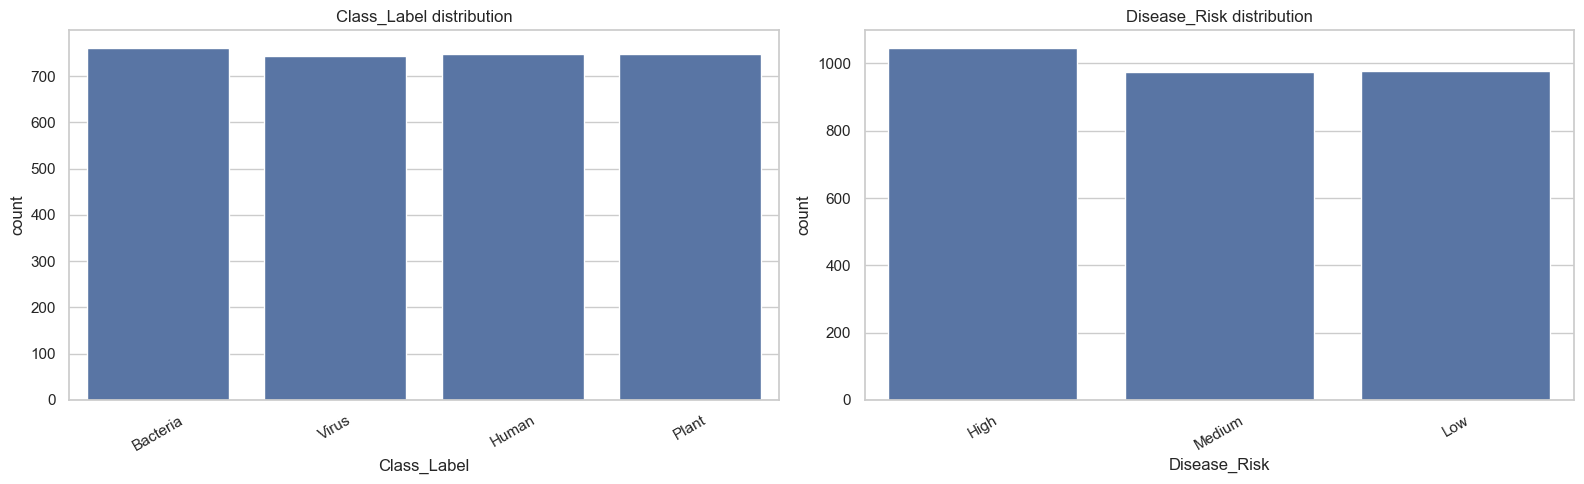

In [7]:
# 3a) Data visualization — Label distributions
import matplotlib.ticker as mticker

fig, axes = plt.subplots(1, 2, figsize=(16,5))
cols = [c for c in ["Class_Label", "Disease_Risk"] if c in df.columns]
for i, col in enumerate(cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} distribution")
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout(); plt.show()

In [8]:
# 4) Missing values check and imputation plan
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing[missing>0])

# We'll impute inside the modeling pipelines; for EDA visuals above we used raw data.
# If a column is entirely missing, drop it here to avoid pipeline errors.
all_missing_cols = missing[missing == len(df)].index.tolist()
if all_missing_cols:
    print("Dropping all-missing columns:", all_missing_cols)
    df = df.drop(columns=all_missing_cols)
else:
    print("No entirely-missing columns detected.")

Missing values per column:
 Series([], dtype: int64)
No entirely-missing columns detected.


In [9]:
# 5) Train/Test Split (stratified on Class_Label if available else last column)
primary_target = 'Class_Label' if 'Class_Label' in df.columns else df.columns[-1]
X_base = df.drop(columns=[primary_target])
y_base = df[primary_target]

X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_base, y_base, test_size=0.2, random_state=RANDOM_STATE, stratify=y_base
)

print("Global split based on:", primary_target)
print("Train size:", X_train_global.shape, "Test size:", X_test_global.shape)

Global split based on: Class_Label
Train size: (2400, 12) Test size: (600, 12)


In [10]:
# 5b) PCA analysis on training data — DISABLED
print("PCA disabled: Skipping PCA analysis and plots.")
USE_PCA = False
PCA_N_COMPONENTS = None


PCA disabled: Skipping PCA analysis and plots.


> Note: PCA analysis and PCA vs no-PCA comparisons are disabled going forward (only ~5 numeric features).
> Any previously generated PCA plots/CSVs are legacy artifacts.

In [11]:
# 6a) Modeling utility — Preprocessor builder

from typing import Optional
from sklearn.decomposition import PCA


def make_preprocessor(X: pd.DataFrame, pca_n_components: Optional[int | float] = None, include_pca: bool = True) -> ColumnTransformer:
    # Identify id-like columns
    id_cols = [c for c in X.columns if 'id' in c.lower()]

    # Separate types
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    obj_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # Drop known high-cardinality raw text columns (e.g., DNA sequence string)
    high_card_names = {c for c in obj_cols if c.lower() in {"sequence", "text", "raw"}}

    # Also drop object columns with excessive cardinality (e.g., >20% unique)
    n_rows = max(len(X), 1)
    for c in obj_cols:
        if c in high_card_names:
            continue
        try:
            uniq_ratio = X[c].nunique(dropna=True) / n_rows
            if uniq_ratio > 0.2:
                high_card_names.add(c)
        except Exception:
            pass

    # Final categorical columns after filtering
    cat_cols = [c for c in obj_cols if c not in high_card_names and c not in id_cols]

    if high_card_names:
        print("Dropping high-cardinality categorical columns from modeling:", sorted(list(high_card_names)))

    # OneHotEncoder with down-collapsing of rare categories when available
    ohe = None
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=10)
    except TypeError:
        try:
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20)
        except TypeError:
            try:
                ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            except TypeError:
                ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    numeric_steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
    if include_pca:
        # Add PCA; n_components can be tuned via GridSearchCV
        numeric_steps.append(("pca", PCA(n_components=pca_n_components)))

    numeric_pipeline = Pipeline(numeric_steps)
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ])

    return ColumnTransformer([
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ], remainder='drop')

In [12]:
# Preprocessing: impute+scale only (no PCA), with high-cardinality text drop
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from typing import Optional

def make_preprocessor(X: pd.DataFrame, pca_n_components: Optional[int | float] = None, include_pca: bool = False) -> ColumnTransformer:
    X_local = X.copy()
    high_card_obj_cols = []
    for c in X_local.select_dtypes(include=['object']).columns:
        uniq_ratio = X_local[c].nunique(dropna=False) / max(1, len(X_local))
        if uniq_ratio >= 0.2 or c.lower() in {'sample_id', 'sequence', 'id', 'uid'}:
            high_card_obj_cols.append(c)
    if high_card_obj_cols:
        print('Dropping high-cardinality categorical columns from modeling:', high_card_obj_cols)
        X_local = X_local.drop(columns=high_card_obj_cols)

    num_cols = X_local.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X_local.select_dtypes(exclude=['number']).columns.tolist()

    numeric_steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
    numeric_pipeline = Pipeline(numeric_steps)

    # Robust OHE across sklearn versions
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=10)
    except TypeError:
        try:
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20)
        except TypeError:
            try:
                ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            except TypeError:
                ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', ohe),
    ])

    return ColumnTransformer([
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols),
    ])

In [13]:
# 8a) Combined predictions for both targets
try:
    out = df.copy()
    if model_class is not None:
        drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != 'Class_Label' and c in out.columns]
        X_all = out.drop(columns=['Class_Label'] + drop_cols)
        # Drop mutation flags for Class_Label predictions
        X_all = drop_mutation_for_class_label(X_all, 'Class_Label')
        out['pred_Class_Label'] = model_class.predict(X_all)
    if model_risk is not None:
        drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != 'Disease_Risk' and c in out.columns]
        X_all = out.drop(columns=['Disease_Risk'] + drop_cols)
        # Keep mutation flags for Disease_Risk predictions (no drop)
        out['pred_Disease_Risk'] = model_risk.predict(X_all)
    pred_path = os.path.join(OUTPUT_DIR, 'predictions_dual.csv')
    out_cols = [c for c in ['Sample_ID', 'Class_Label', 'Disease_Risk', 'pred_Class_Label', 'pred_Disease_Risk'] if c in out.columns]
    out[out_cols].to_csv(pred_path, index=False)
    print('Saved predictions to:', pred_path)
except Exception as e:
    print('Prediction export failed:', e)

Prediction export failed: name 'model_class' is not defined


In [14]:
# 8c) Calibration curves (OvR) per target
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize


def plot_calibration_curves(model, X_te, y_te, classes, tag):
    # Try to get scores/probas
    probas = None
    scores = None
    if hasattr(model, 'predict_proba'):
        try:
            probas = model.predict_proba(X_te)
        except Exception:
            probas = None
    if probas is None and hasattr(model, 'decision_function'):
        try:
            scores = model.decision_function(X_te)
        except Exception:
            scores = None
    if probas is None and scores is None:
        print(f"Calibration skipped for {tag}: model lacks probability/score outputs.")
        return

    is_binary = len(classes) == 2
    if is_binary:
        if probas is not None:
            y_score = probas[:, list(model.classes_).index(classes[-1])]
        else:
            y_score = scores if scores.ndim == 1 else scores[:, list(model.classes_).index(classes[-1])]
        frac_pos, mean_pred = calibration_curve((y_te == classes[-1]).astype(int), y_score, n_bins=10, strategy='uniform')
        plt.figure(figsize=(6,6))
        plt.plot(mean_pred, frac_pos, 'o-', label='Calibrated')
        plt.plot([0,1],[0,1],'k--', label='Perfectly calibrated')
        plt.title(f'{tag} Calibration Curve')
        plt.legend(); plt.tight_layout()
        path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_calibration.png')
        plt.savefig(path, dpi=120); plt.show()
        print('Saved calibration to:', path)
    else:
        y_bin = label_binarize(y_te, classes=classes)
        plt.figure(figsize=(10,8))
        for i, cls in enumerate(classes):
            y_score_i = probas[:, i] if probas is not None else scores[:, i]
            frac_pos, mean_pred = calibration_curve(y_bin[:, i], y_score_i, n_bins=10, strategy='uniform')
            plt.plot(mean_pred, frac_pos, 'o-', label=str(cls))
        plt.plot([0,1],[0,1],'k--', label='Perfectly calibrated')
        plt.title(f'{tag} Calibration Curves (OvR)')
        plt.legend(); plt.tight_layout()
        path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_calibration.png')
        plt.savefig(path, dpi=120); plt.show()
        print('Saved calibration to:', path)

# Build eval splits and plot for both models if available
for tag, model in [('Disease_Risk', globals().get('model_risk')), ('Class_Label', globals().get('model_class'))]:
    if model is None or tag not in df.columns:
        continue
    # Reconstruct split for this target
    drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != tag and c in df.columns]
    X = df.drop(columns=[tag] + drop_cols)
    # Apply mutation drop only for Class_Label
    X = drop_mutation_for_class_label(X, tag)
    y = df[tag].astype('category')
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    classes = sorted(y_tr.unique().tolist())
    plot_calibration_curves(model, X_te, y_te, classes, tag)

In [15]:
# 8d) Binary threshold tuning (skips multiclass)
from sklearn.metrics import auc, precision_recall_curve, roc_curve


def threshold_sweep(model, X_te, y_te, classes, tag):
    is_binary = len(classes) == 2
    if not is_binary:
        print(f"Threshold sweep skipped for {tag}: multiclass detected.")
        return
    # scores/probas for positive class
    pos = classes[-1]
    probas = None
    scores = None
    if hasattr(model, 'predict_proba'):
        try:
            probas = model.predict_proba(X_te)
        except Exception:
            probas = None
    if probas is None and hasattr(model, 'decision_function'):
        try:
            scores = model.decision_function(X_te)
        except Exception:
            scores = None
    if probas is None and scores is None:
        print(f"Threshold sweep skipped for {tag}: no probability/score output.")
        return
    if probas is not None:
        y_score = probas[:, list(model.classes_).index(pos)]
    else:
        y_score = scores if scores.ndim == 1 else scores[:, list(model.classes_).index(pos)]

    y_true = (y_te == pos).astype(int)
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    fpr, tpr, roc_thr = roc_curve(y_true, y_score)
    pr_auc = auc(rec, prec)
    roc_auc_v = auc(fpr, tpr)

    # Plot PR and ROC with thresholds
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(rec, prec, label=f'AP={pr_auc:.3f}')
    axes[0].set_title(f'{tag} Precision-Recall')
    axes[0].legend()
    axes[1].plot(fpr, tpr, label=f'AUC={roc_auc_v:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title(f'{tag} ROC')
    axes[1].legend()
    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_threshold_sweep.png')
    plt.savefig(path, dpi=120)
    plt.show()

    # Export sweep table
    import pandas as pd
    # thr is length N-1 vs prec/rec length N; pad to align
    thr_aligned = np.r_[thr, thr[-1] if len(thr) else 0.5]
    df_sweep = pd.DataFrame({'threshold': thr_aligned, 'precision': prec, 'recall': rec})
    tpath = os.path.join(OUTPUT_DIR, f'{tag.lower()}_threshold_sweep.csv')
    df_sweep.to_csv(tpath, index=False)
    print('Saved threshold sweep to:', tpath)

# Execute for both targets if they are binary
for tag, model in [('Disease_Risk', globals().get('model_risk')), ('Class_Label', globals().get('model_class'))]:
    if model is None or tag not in df.columns:
        continue
    drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != tag and c in df.columns]
    X = df.drop(columns=[tag] + drop_cols)
    # Apply mutation drop only for Class_Label
    X = drop_mutation_for_class_label(X, tag)
    y = df[tag].astype('category')
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    classes = sorted(y_tr.unique().tolist())
    threshold_sweep(model, X_te, y_te, classes, tag)

In [ ]:
# 3b) Data visualization — Numeric histograms
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    df[num_cols].hist(bins=20, figsize=(14,10))
    plt.suptitle("Numeric Feature Histograms", y=1.02)
    plt.tight_layout(); plt.show()

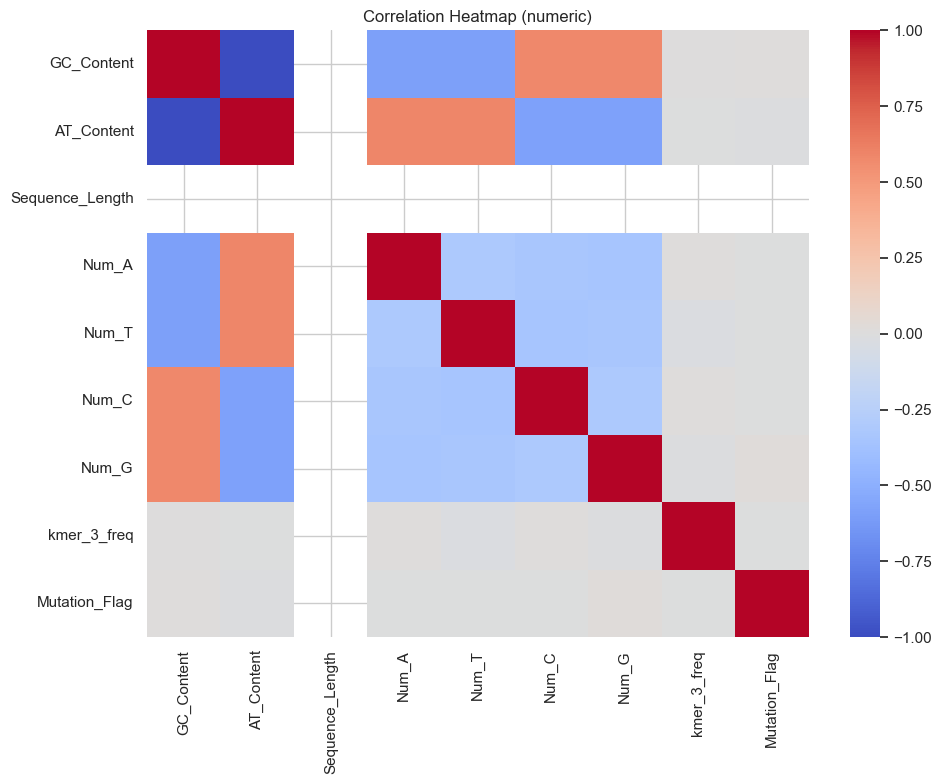

In [ ]:
# 3c) Data visualization — Correlation heatmap (numeric only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap (numeric)')
    plt.tight_layout(); plt.show()

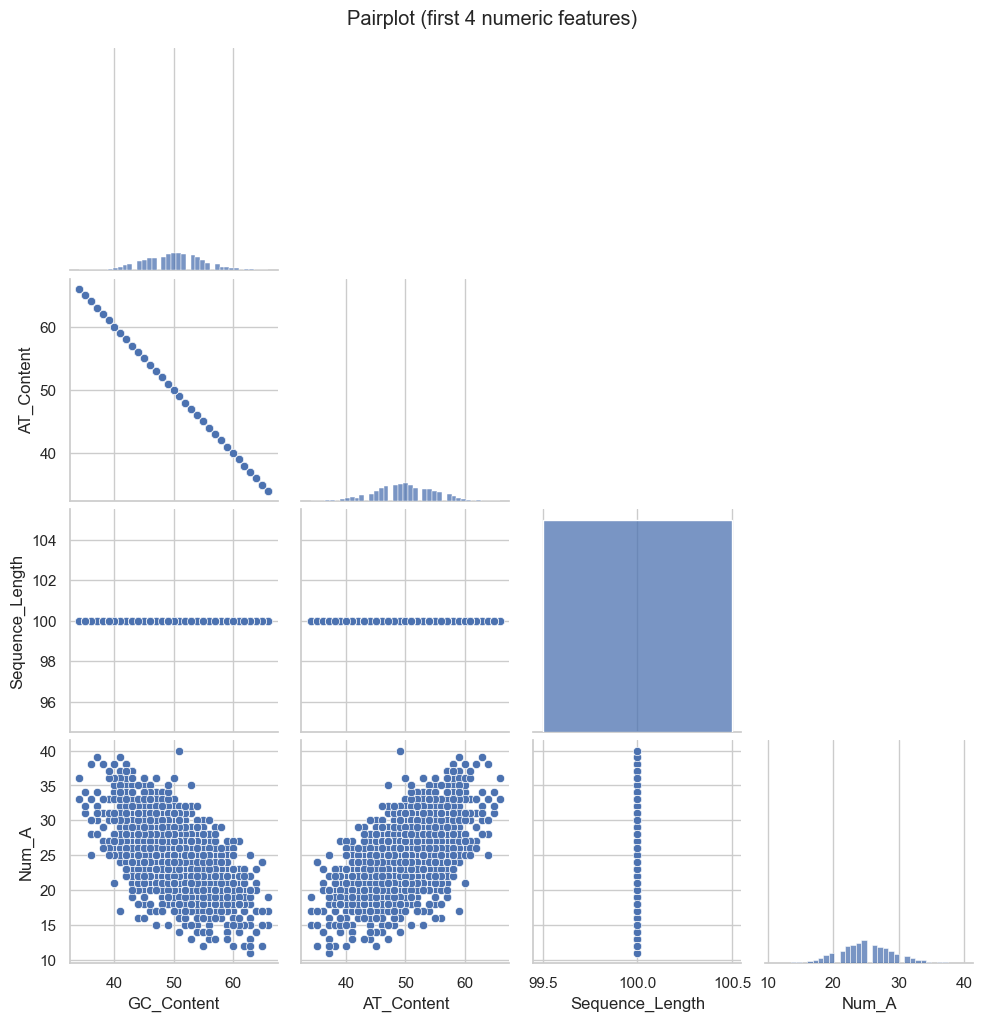

In [ ]:
# 3d) Data visualization — Pairplot (first 4 numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 3:
    sns.pairplot(df[num_cols[:4]], corner=True)
    plt.suptitle('Pairplot (first 4 numeric features)', y=1.02)
    plt.show()

In [ ]:
# 5b) Remove PCA analysis entirely — enforced no-PCA pipeline
print("PCA analysis removed: Skipping PCA EVR computation and plots.")
USE_PCA = False
PCA_N_COMPONENTS = None
# No PCA imports or computations below.


PCA analysis removed: Skipping PCA EVR computation and plots.


In [ ]:
# Remove PCA import and legacy flags; enforce no-PCA downstream
print("Removing PCA remnants from preprocessor builder.")
# No PCA import; redefine builder without PCA
from typing import Optional
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

USE_PCA = False
PCA_N_COMPONENTS = None

# Overwrite previous function signature to ignore PCA params
def make_preprocessor(X: pd.DataFrame, pca_n_components: Optional[int | float] = None, include_pca: bool = False) -> ColumnTransformer:
    X_local = X.copy()
    high_card_obj_cols = []
    for c in X_local.select_dtypes(include=['object']).columns:
        uniq_ratio = X_local[c].nunique(dropna=False) / max(1, len(X_local))
        if uniq_ratio >= 0.2 or c.lower() in {'sample_id', 'sequence', 'id', 'uid'}:
            high_card_obj_cols.append(c)
    if high_card_obj_cols:
        print('Dropping high-cardinality categorical columns from modeling:', high_card_obj_cols)
        X_local = X_local.drop(columns=high_card_obj_cols)

    num_cols = X_local.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X_local.select_dtypes(exclude=['number']).columns.tolist()

    numeric_steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
    numeric_pipeline = Pipeline(numeric_steps)

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ])

    return ColumnTransformer([
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols),
    ])

Removing PCA remnants from preprocessor builder.


In [ ]:
# 6b) Evaluation utilities and training function (no PCA, no parallel joblib)
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


def _get_scores(model, X):
    probas = None
    scores = None
    if hasattr(model, 'predict_proba'):
        try:
            probas = model.predict_proba(X)
        except Exception:
            probas = None
    if probas is None and hasattr(model, 'decision_function'):
        try:
            scores = model.decision_function(X)
        except Exception:
            scores = None
    return probas, scores


def evaluate_and_plots(model, X_tr, y_tr, X_te, y_te, tag, classes):
    # Predictions
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)

    # Core metrics
    metrics = {
        'train': {
            'accuracy': float(accuracy_score(y_tr, y_pred_tr)),
            'precision_macro': float(precision_score(y_tr, y_pred_tr, average='macro', zero_division=0)),
            'recall_macro': float(recall_score(y_tr, y_pred_tr, average='macro', zero_division=0)),
            'f1_macro': float(f1_score(y_tr, y_pred_tr, average='macro', zero_division=0)),
        },
        'test': {
            'accuracy': float(accuracy_score(y_te, y_pred_te)),
            'precision_macro': float(precision_score(y_te, y_pred_te, average='macro', zero_division=0)),
            'recall_macro': float(recall_score(y_te, y_pred_te, average='macro', zero_division=0)),
            'f1_macro': float(f1_score(y_te, y_pred_te, average='macro', zero_division=0)),
        },
        'classification_report': classification_report(y_te, y_pred_te, zero_division=0, output_dict=True),
    }

    # Confusion matrices - regular counts
    try:
        import matplotlib.pyplot as plt, os
        cm_tr = confusion_matrix(y_tr, y_pred_tr, labels=classes)
        cm_te = confusion_matrix(y_te, y_pred_te, labels=classes)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.heatmap(cm_tr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title(f'{tag} Train Confusion')
        axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
        sns.heatmap(cm_te, annot=True, fmt='d', cmap='Greens', ax=axes[1])
        axes[1].set_title(f'{tag} Test Confusion')
        axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
        plt.tight_layout()
        path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_confusions.png')
        plt.savefig(path, dpi=120); plt.show()
        metrics['confusion_image'] = path
        
        # Confusion matrices - normalized
        cm_tr_norm = confusion_matrix(y_tr, y_pred_tr, labels=classes, normalize='true')
        cm_te_norm = confusion_matrix(y_te, y_pred_te, labels=classes, normalize='true')
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.heatmap(cm_tr_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0])
        axes[0].set_title(f'{tag} Train Confusion (Normalized)')
        axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
        sns.heatmap(cm_te_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
        axes[1].set_title(f'{tag} Test Confusion (Normalized)')
        axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
        plt.tight_layout()
        path_norm = os.path.join(OUTPUT_DIR, f'{tag.lower()}_confusions_normalized.png')
        plt.savefig(path_norm, dpi=120); plt.show()
        metrics['confusion_normalized_image'] = path_norm
    except Exception as e:
        print('Confusion matrix plot failed:', e)

    # ROC/PR curves (OvR for multiclass)
    try:
        probas_tr, scores_tr = _get_scores(model, X_tr)
        probas_te, scores_te = _get_scores(model, X_te)
        if probas_te is not None or scores_te is not None:
            is_binary = len(classes) == 2
            plt.figure(figsize=(12, 5))
            # ROC
            plt.subplot(1, 2, 1)
            if is_binary:
                pos = classes[-1]
                if probas_te is not None:
                    y_score = probas_te[:, list(model.classes_).index(pos)]
                else:
                    y_score = scores_te if scores_te.ndim == 1 else scores_te[:, list(model.classes_).index(pos)]
                y_true = (y_te == pos).astype(int)
                fpr, tpr, _ = roc_curve(y_true, y_score)
                roc_auc_v = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'AUC={roc_auc_v:.3f}')
                plt.plot([0,1],[0,1],'k--')
                plt.title(f'{tag} ROC')
                plt.legend()
                metrics['test']['roc_auc'] = float(roc_auc_v)
            else:
                y_bin = label_binarize(y_te, classes=classes)
                roc_aucs = {}
                for i, cls in enumerate(classes):
                    y_score = probas_te[:, i] if probas_te is not None else scores_te[:, i]
                    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score)
                    roc_auc_v = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f'{cls} AUC={roc_auc_v:.2f}')
                    roc_aucs[str(cls)] = float(roc_auc_v)
                plt.plot([0,1],[0,1],'k--')
                plt.title(f'{tag} ROC (OvR)')
                plt.legend(fontsize=8)
                metrics['test']['roc_auc_ovr'] = roc_aucs
            # PR
            plt.subplot(1, 2, 2)
            if is_binary:
                pos = classes[-1]
                if probas_te is not None:
                    y_score = probas_te[:, list(model.classes_).index(pos)]
                else:
                    y_score = scores_te if scores_te.ndim == 1 else scores_te[:, list(model.classes_).index(pos)]
                y_true = (y_te == pos).astype(int)
                prec, rec, _ = precision_recall_curve(y_true, y_score)
                pr_auc = auc(rec, prec)
                plt.plot(rec, prec, label=f'AP={pr_auc:.3f}')
                plt.title(f'{tag} Precision-Recall')
                plt.legend()
                metrics['test']['pr_auc'] = float(pr_auc)
            else:
                y_bin = label_binarize(y_te, classes=classes)
                pr_aucs = {}
                for i, cls in enumerate(classes):
                    y_score = probas_te[:, i] if probas_te is not None else scores_te[:, i]
                    prec, rec, _ = precision_recall_curve(y_bin[:, i], y_score)
                    pr_auc = auc(rec, prec)
                    plt.plot(rec, prec, label=f'{cls} AP={pr_auc:.2f}')
                    pr_aucs[str(cls)] = float(pr_auc)
                plt.title(f'{tag} Precision-Recall (OvR)')
                plt.legend(fontsize=8)
                metrics['test']['pr_auc_ovr'] = pr_aucs
            plt.tight_layout()
            path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_roc_pr.png')
            plt.savefig(path, dpi=120); plt.show()
            metrics['roc_pr_image'] = path
    except Exception as e:
        print('ROC/PR plotting failed:', e)

    return metrics


def train_one_target(df_in: pd.DataFrame, target: str, tag: str, pca_n_components: int | None = None):
    # Prepare split with leakage-safe drops
    drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != target and c in df_in.columns]
    X = df_in.drop(columns=[target] + drop_cols)
    y = df_in[target].astype('category')
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    pre = make_preprocessor(X_tr, include_pca=False)

    models = {
        'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
        'LinearSVC(calibrated)': CalibratedClassifierCV(LinearSVC(class_weight='balanced', random_state=RANDOM_STATE), cv=3),
    }

    cv = RepeatedStratifiedKFold(n_splits=50, n_repeats=5, random_state=RANDOM_STATE)

    best_name, best_estimator, best_score = None, None, -np.inf
    cv_results = {}

    for name, est in models.items():
        pipe = Pipeline([('preprocess', pre), ('clf', est)])
        if isinstance(est, LogisticRegression):
            param_grid = {'clf__C': [0.1, 0.3, 0.5, 1.0]}
            gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=1, refit=True)
            gs.fit(X_tr, y_tr)
        else:
            gs = None; last_err = None
            for svc_key in ['clf__estimator__C', 'clf__base_estimator__C']:
                try:
                    param_grid = {svc_key: [0.1, 0.3, 0.5, 1.0]}
                    gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=1, refit=True)
                    gs.fit(X_tr, y_tr)
                    last_err = None
                    break
                except Exception as e:
                    last_err = e; gs = None
            if gs is None and last_err is not None:
                raise last_err

        cv_results[name] = {'best_params': gs.best_params_, 'best_cv_f1_macro': float(gs.best_score_)}
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_estimator = gs.best_estimator_
            best_name = name

    classes = sorted(y_tr.unique().tolist())
    metrics = evaluate_and_plots(best_estimator, X_tr, y_tr, X_te, y_te, tag, classes)

    # Persist artifacts
    import os, json
    try:
        import joblib
        joblib.dump(best_estimator, os.path.join(OUTPUT_DIR, f'{tag.lower()}_model.joblib'))
    except Exception as e:
        print('Model save failed:', e)
    with open(os.path.join(OUTPUT_DIR, f'{tag.lower()}_metrics.json'), 'w') as f:
        json.dump({'best_model': best_name, 'cv_results': cv_results, **metrics}, f, indent=2)

    return best_estimator, metrics

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\bhara\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bhara\AppData\Local\Temp\ipykernel_39840\712245380.py", line 159, in <module>
    def train_one_target(df_in: pd.DataFrame, target: str, tag: str, pca_n_components: int | None = None):
                                ^^
NameError: name 'pd' is not defined. Did you mean: 'id'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bhara\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 2194, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "C:\Users\bhara\AppData\Roaming\Python\Python313\site-packages\IPython\core\ultratb.py"

Dropping high-cardinality categorical columns from modeling: ['Sample_ID', 'Sequence']


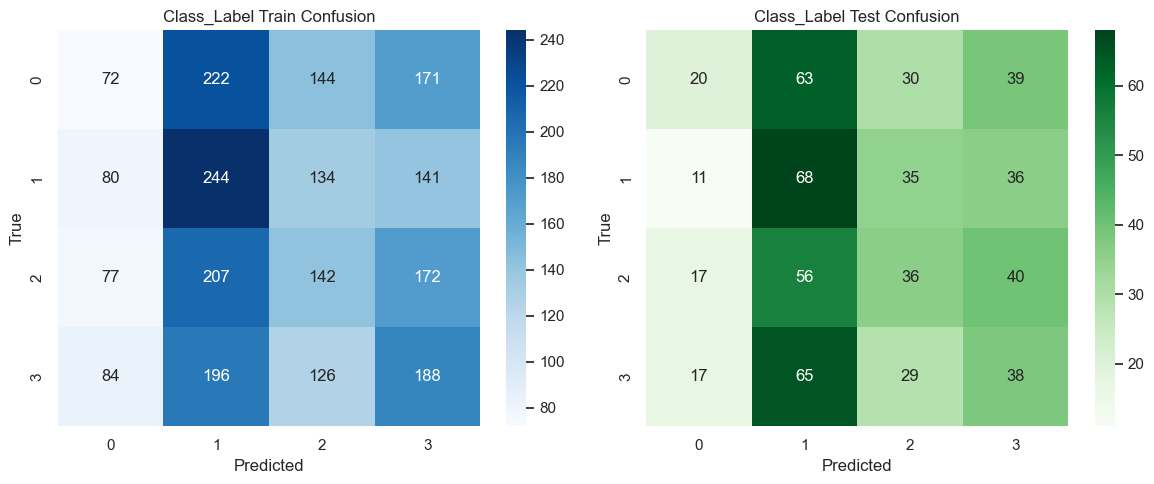

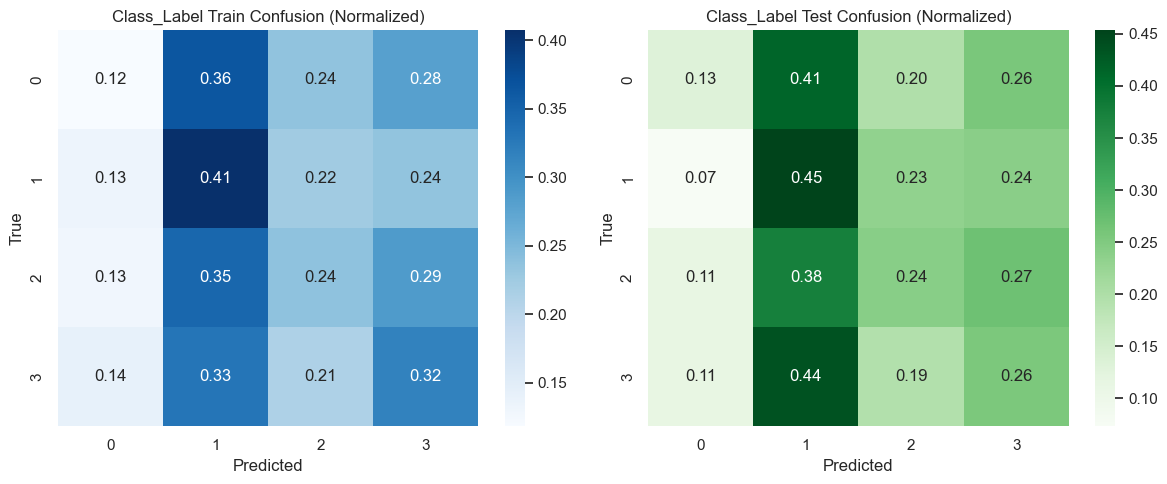

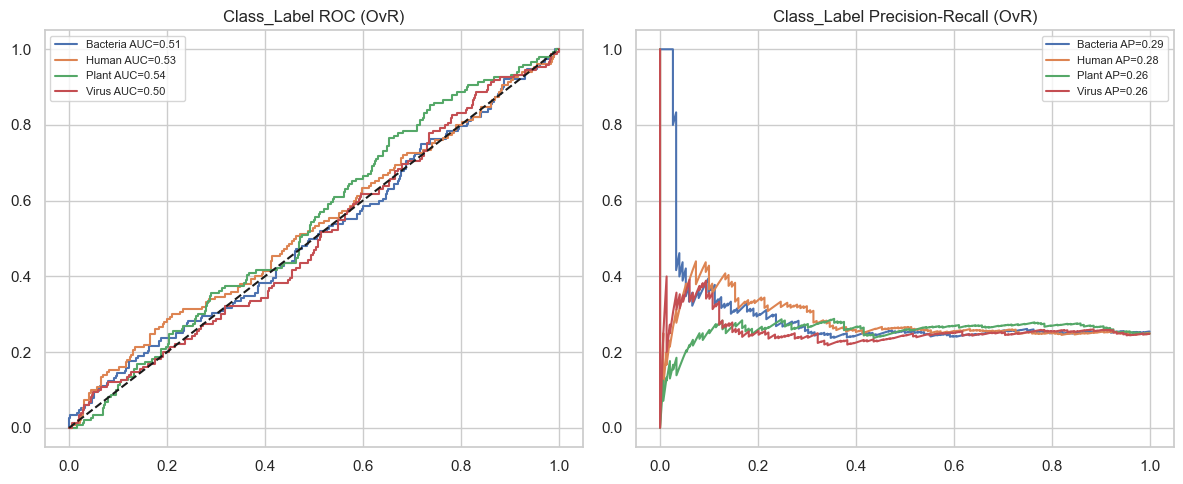

Class_Label metrics:
 {
  "train": {
    "accuracy": 0.26916666666666667,
    "precision_macro": 0.2626624055868909,
    "recall_macro": 0.26988217185585117,
    "f1_macro": 0.2584643622935383
  },
  "test": {
    "accuracy": 0.27,
    "precision_macro": 0.2757056668821375,
    "recall_macro": 0.27038914400094194,
    "f1_macro": 0.25809010005364275,
    "roc_auc_ovr": {
      "Bacteria": 0.5050076362781954,
      "Human": 0.5266666666666666,
      "Plant": 0.5396508876620187,
      "Virus": 0.5005282816708582
    },
    "pr_auc_ovr": {
      "Bacteria": 0.2929599388249982,
      "Human": 0.28069080726736895,
      "Plant": 0.257586353121643,
      "Virus": 0.2557276304953889
    }
  },
  "classification_report": {
    "Bacteria": {
      "precision": 0.3076923076923077,
      "recall": 0.13157894736842105,
      "f1-score": 0.18433179723502305,
      "support": 152.0
    },
    "Human": {
      "precision": 0.2698412698412698,
      "recall": 0.4533333333333333,
      "f1-score": 0.33

In [ ]:
# 7c) Train Class_Label
model_class = metrics_class = None
if 'Class_Label' in df.columns:
    model_class, metrics_class = train_one_target(df, 'Class_Label', 'Class_Label')
    print("Class_Label metrics:\n", json.dumps(metrics_class, indent=2))

Dropping high-cardinality categorical columns from modeling: ['Sample_ID', 'Sequence']


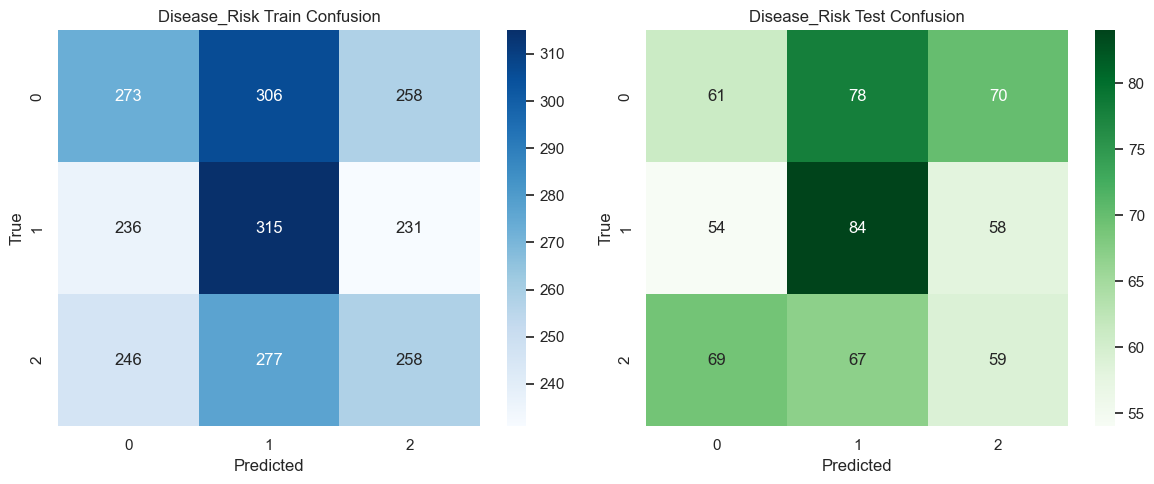

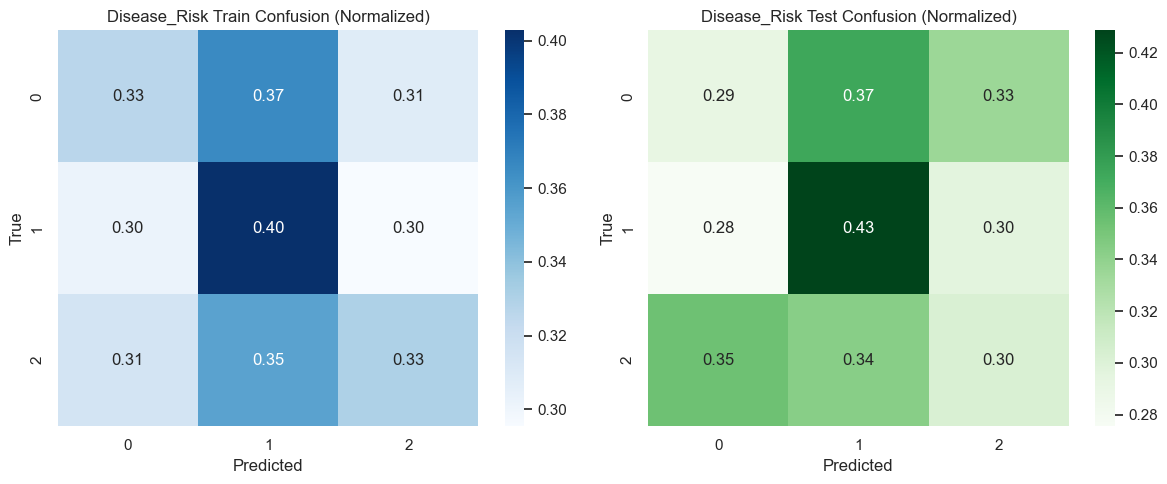

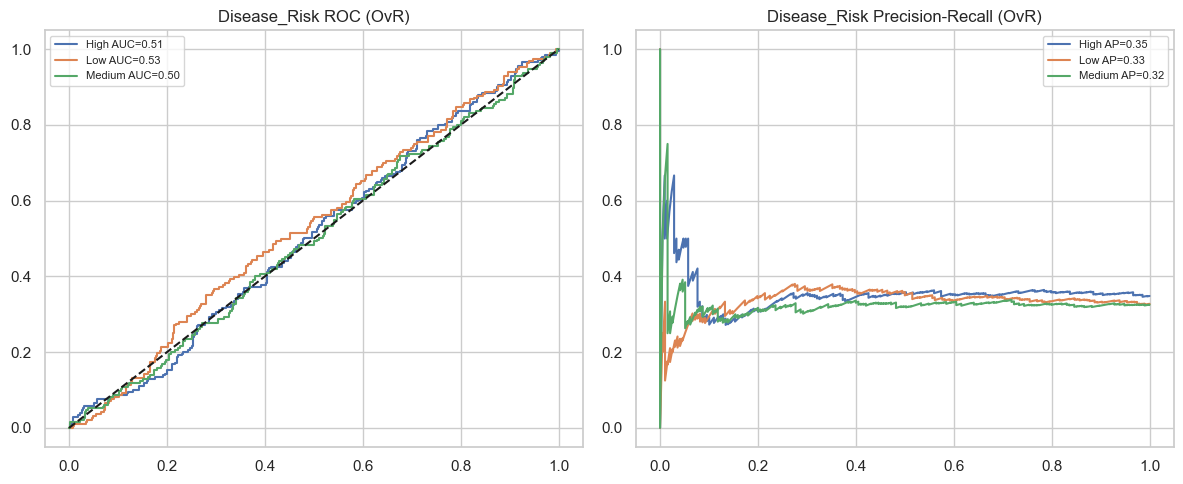

Disease_Risk metrics:
 {
  "train": {
    "accuracy": 0.3525,
    "precision_macro": 0.3525834800333998,
    "recall_macro": 0.3531079614707029,
    "f1_macro": 0.3518870530663791
  },
  "test": {
    "accuracy": 0.34,
    "precision_macro": 0.3379473291983483,
    "recall_macro": 0.3410005199478883,
    "f1_macro": 0.33820907039394094,
    "roc_auc_ovr": {
      "High": 0.5065162324551206,
      "Low": 0.5319761567993535,
      "Medium": 0.4983982272871161
    },
    "pr_auc_ovr": {
      "High": 0.35378809948435974,
      "Low": 0.3346412296213118,
      "Medium": 0.3235915870880899
    }
  },
  "classification_report": {
    "High": {
      "precision": 0.33152173913043476,
      "recall": 0.291866028708134,
      "f1-score": 0.3104325699745547,
      "support": 209.0
    },
    "Low": {
      "precision": 0.36681222707423583,
      "recall": 0.42857142857142855,
      "f1-score": 0.3952941176470588,
      "support": 196.0
    },
    "Medium": {
      "precision": 0.3155080213903743

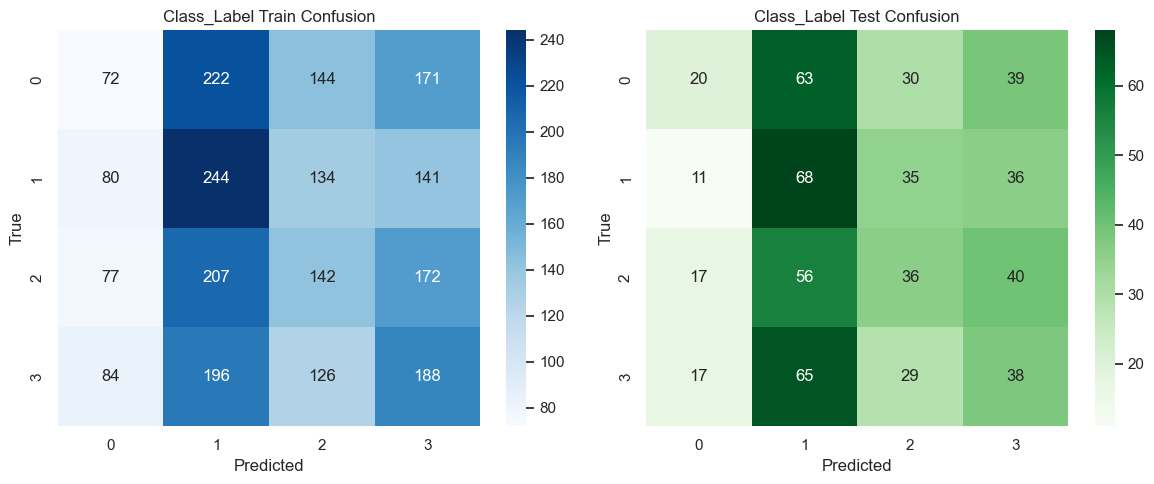

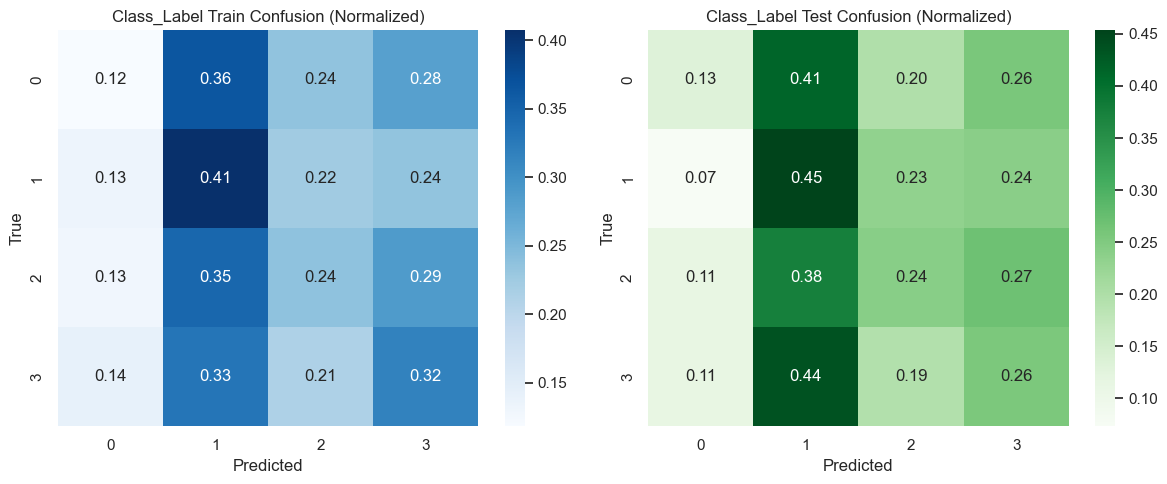

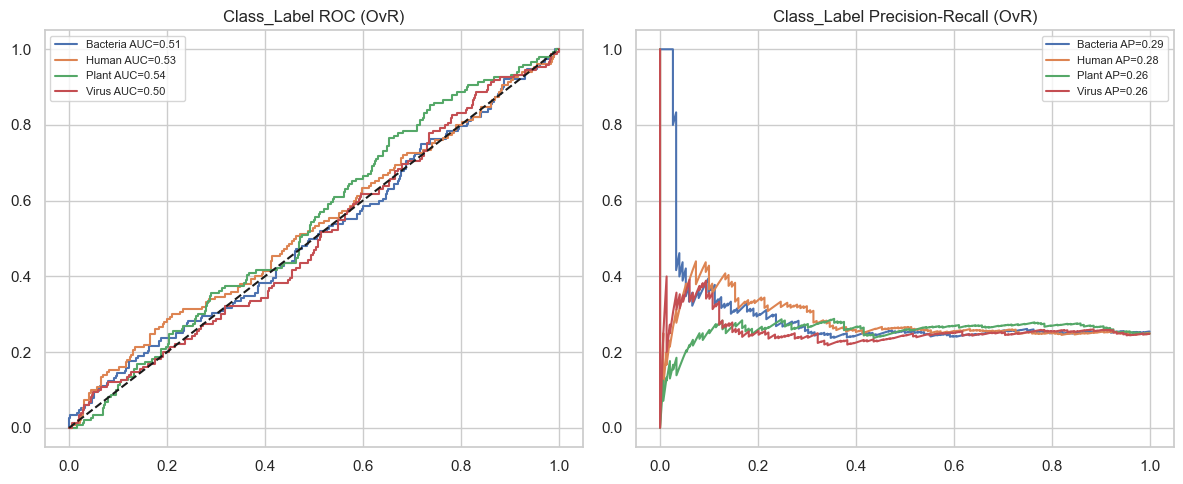

Class_Label metrics:
 {
  "train": {
    "accuracy": 0.26916666666666667,
    "precision_macro": 0.2626624055868909,
    "recall_macro": 0.26988217185585117,
    "f1_macro": 0.2584643622935383
  },
  "test": {
    "accuracy": 0.27,
    "precision_macro": 0.2757056668821375,
    "recall_macro": 0.27038914400094194,
    "f1_macro": 0.25809010005364275,
    "roc_auc_ovr": {
      "Bacteria": 0.5050076362781954,
      "Human": 0.5266666666666666,
      "Plant": 0.5396508876620187,
      "Virus": 0.5005282816708582
    },
    "pr_auc_ovr": {
      "Bacteria": 0.2929599388249982,
      "Human": 0.28069080726736895,
      "Plant": 0.257586353121643,
      "Virus": 0.2557276304953889
    }
  },
  "classification_report": {
    "Bacteria": {
      "precision": 0.3076923076923077,
      "recall": 0.13157894736842105,
      "f1-score": 0.18433179723502305,
      "support": 152.0
    },
    "Human": {
      "precision": 0.2698412698412698,
      "recall": 0.4533333333333333,
      "f1-score": 0.33

In [ ]:
# 7c) Train Disease_Risk and Class_Label
model_risk = metrics_risk = None
model_class = metrics_class = None

if 'Disease_Risk' in df.columns:
    model_risk, metrics_risk = train_one_target(df, 'Disease_Risk', 'Disease_Risk')
    print("Disease_Risk metrics:\n", json.dumps(metrics_risk, indent=2))
else:
    print('Disease_Risk not in df')

if 'Class_Label' in df.columns:
    model_class, metrics_class = train_one_target(df, 'Class_Label', 'Class_Label')
    print("Class_Label metrics:\n", json.dumps(metrics_class, indent=2))
else:
    print('Class_Label not in df')

In [ ]:
# 7d) PCA vs No-PCA comparison (per target) — skipped
print("PCA comparison skipped: PCA is disabled (only 5 features).")
# Original implementation replaced by global PCA-disable override cell at the end of the notebook.
# If needed later, restore the original comparison logic and enable PCA in the preprocessor.

PCA comparison skipped: PCA is disabled (only 5 features).


In [ ]:
# 8b) Artifact recap
print('Artifacts saved under:', OUTPUT_DIR)
for f in sorted(os.listdir(OUTPUT_DIR)):
    print(' -', os.path.join(OUTPUT_DIR, f))

Artifacts saved under: c:\\Users\\bhara\\Downloads\\ML\\2\\outputs
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\class_label_confusions.png
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\class_label_confusions_normalized.png
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\class_label_metrics.json
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\class_label_model.joblib
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\class_label_roc_pr.png
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_calibration.png
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_confusions.png
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_confusions_normalized.png
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_metrics.json
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_model.joblib
 - c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_roc_pr.png


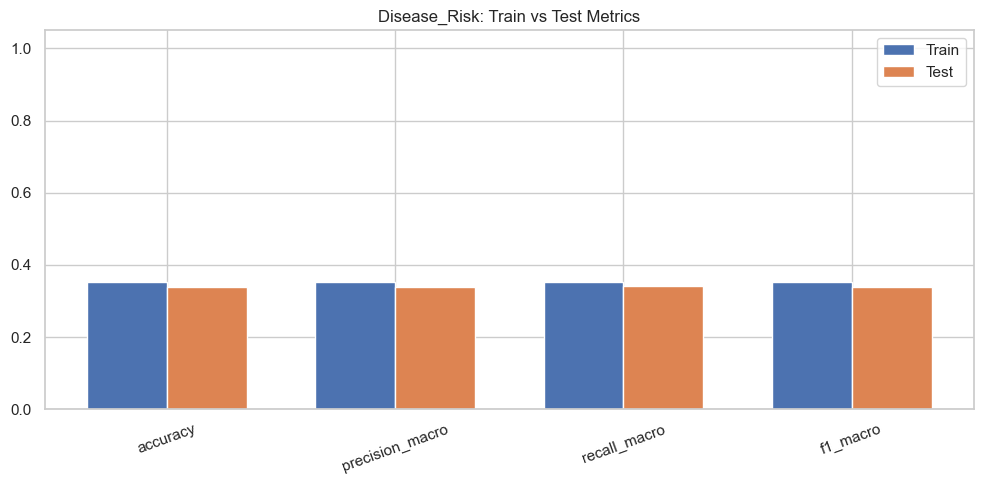

Saved: c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\disease_risk_train_test_metrics.png


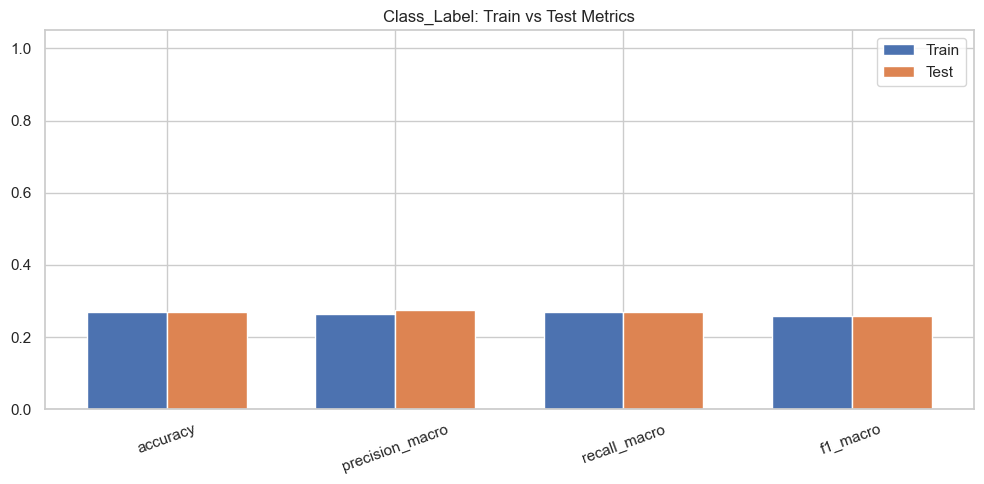

Saved: c:\\Users\\bhara\\Downloads\\ML\\2\\outputs\class_label_train_test_metrics.png


In [ ]:
# 8a) Train vs Test metrics bar charts for both targets
import matplotlib.pyplot as plt
import numpy as np
import os

# Prepare a helper to plot metrics
_DEF_METRICS = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

def _plot_train_test_metrics(metrics_dict, title_tag):
    vals_tr = [metrics_dict['train'].get(m, np.nan) for m in _DEF_METRICS]
    vals_te = [metrics_dict['test'].get(m, np.nan) for m in _DEF_METRICS]
    x = np.arange(len(_DEF_METRICS))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, vals_tr, width, label='Train')
    ax.bar(x + width/2, vals_te, width, label='Test')
    ax.set_xticks(x)
    ax.set_xticklabels(_DEF_METRICS, rotation=20)
    ax.set_ylim(0, 1.05)
    ax.set_title(f'{title_tag}: Train vs Test Metrics')
    ax.legend()
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, f"{title_tag.lower()}_train_test_metrics.png")
    plt.savefig(out_path, dpi=120)
    plt.show()
    print('Saved:', out_path)

if metrics_risk is not None:
    _plot_train_test_metrics(metrics_risk, 'Disease_Risk')
else:
    print('No metrics for Disease_Risk')

if metrics_class is not None:
    _plot_train_test_metrics(metrics_class, 'Class_Label')
else:
    print('No metrics for Class_Label')

In [ ]:
# DEBUG: Inspect parameter names for pipeline grid (PCA disabled)
try:
    pre_dbg = make_preprocessor(X_train_global, include_pca=False)
    pipe_dbg = Pipeline([
        ('preprocess', pre_dbg),
        ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced', random_state=RANDOM_STATE), cv=3))
    ])
    keys = pipe_dbg.get_params().keys()
    print('PCA keys present:', any('pca' in k for k in keys))
    cand = [k for k in keys if 'estimator' in k or 'base_estimator' in k]
    for k in sorted(cand):
        print(k)
except Exception as e:
    print('Debug param inspection failed:', repr(e))

Dropping high-cardinality categorical columns from modeling: ['Sample_ID', 'Sequence']
PCA keys present: False
clf__estimator
clf__estimator__C
clf__estimator__class_weight
clf__estimator__dual
clf__estimator__fit_intercept
clf__estimator__intercept_scaling
clf__estimator__loss
clf__estimator__max_iter
clf__estimator__multi_class
clf__estimator__penalty
clf__estimator__random_state
clf__estimator__tol
clf__estimator__verbose


In [ ]:
# DEBUG: Minimal GS test for Disease_Risk with LogReg only (no PCA)
try:
    tgt = 'Disease_Risk'
    if tgt in df.columns:
        drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != tgt and c in df.columns]
        X = df.drop(columns=[tgt] + drop_cols)
        y = df[tgt].astype('category')
        X_tr, _, y_tr, _ = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        pre = make_preprocessor(X_tr, include_pca=False)
        pipe = Pipeline([('preprocess', pre), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))])
        rskf_small = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=RANDOM_STATE)
        gs = GridSearchCV(pipe, {'clf__C': [0.1, 0.3, 0.5, 1.0]}, scoring='f1_macro', cv=rskf_small, n_jobs=1, refit=True)
        gs.fit(X_tr, y_tr)
        print('LogReg GS OK; best:', gs.best_params_, 'score=', gs.best_score_)
    else:
        print('Disease_Risk not in df')
except Exception as e:
    import traceback, sys
    print('LogReg GS failed:', repr(e))
    traceback.print_exc()

Dropping high-cardinality categorical columns from modeling: ['Sample_ID', 'Sequence']
LogReg GS OK; best: {'clf__C': 0.3} score= 0.3446284890828803
LogReg GS OK; best: {'clf__C': 0.3} score= 0.3446284890828803


In [ ]:
# Global PCA disable enforcement and training override (final)
print("PCA fully disabled. All preprocessing uses impute+scale only; any PCA analysis/comparison is skipped.")
USE_PCA = False
PCA_N_COMPONENTS = None

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from typing import Tuple, Dict

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set up output directory
OUTPUT_DIR = r"c:\\Users\\bhara\\Downloads\\ML\\2\\outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize

# Ensure the preprocessor builder in-scope has no PCA
# (redeclared earlier; rely on that and just use include_pca=False everywhere.)

def train_one_target(df_in: pd.DataFrame, target: str, tag: str, pca_n_components: int | None = None) -> Tuple[Pipeline, Dict]:
    drop_cols = [c for c in ['Class_Label', 'Disease_Risk'] if c != target and c in df_in.columns]
    X = df_in.drop(columns=[target] + drop_cols)
    y = df_in[target].astype('category')
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    pre = make_preprocessor(X_tr, include_pca=False)

    models = {
        'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
        'LinearSVC(calibrated)': CalibratedClassifierCV(LinearSVC(class_weight='balanced', random_state=RANDOM_STATE), cv=3),
    }

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

    best_name, best_estimator, best_score = None, None, -np.inf
    cv_results = {}

    for name, est in models.items():
        pipe = Pipeline([('preprocess', pre), ('clf', est)])
        if isinstance(est, LogisticRegression):
            param_grid = {'clf__C': [0.1, 0.3, 0.5, 1.0]}
            gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=1, refit=True)
            gs.fit(X_tr, y_tr)
        else:
            gs = None; last_err = None
            for svc_key in ['clf__estimator__C', 'clf__base_estimator__C']:
                try:
                    param_grid = {svc_key: [0.1, 0.3, 0.5, 1.0]}
                    gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=1, refit=True)
                    gs.fit(X_tr, y_tr)
                    last_err = None
                    break
                except Exception as e:
                    last_err = e; gs = None
            if gs is None and last_err is not None:
                raise last_err

        cv_results[name] = {'best_params': gs.best_params_, 'best_cv_f1_macro': float(gs.best_score_)}
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_estimator = gs.best_estimator_
            best_name = name

    classes = sorted(y_tr.unique().tolist())
    metrics = evaluate_and_plots(best_estimator, X_tr, y_tr, X_te, y_te, tag, classes)

    model_path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_model.joblib')
    try:
        import joblib; joblib.dump(best_estimator, model_path)
    except Exception as e:
        print('Model save failed:', e)
    metrics_path = os.path.join(OUTPUT_DIR, f'{tag.lower()}_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump({'best_model': best_name, 'cv_results': cv_results, **metrics}, f, indent=2)
    print('Saved model to:', model_path)
    print('Saved metrics to:', metrics_path)

    return best_estimator, metrics

# No-op PCA comparison

def compare_pca_for_target(df_in: pd.DataFrame, target: str, tag: str):
    print(f"PCA comparison skipped for {tag}: PCA disabled.")
    return None

PCA fully disabled. All preprocessing uses impute+scale only; any PCA analysis/comparison is skipped.
